# Assignment 2

In [1]:
# Import Libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import fa2
import math
import community
import matplotlib.cm as cm
from __future__ import division
import matplotlib.image as mpimg
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import io
from collections import Counter
from wordcloud import WordCloud
# Rendering Parameters
title_font = {'family': 'sans-serif',
        'color':  '#000000',
        'weight': 'normal',
        'size': 16,
        }

## Part 1: Twitter Network Analysis

### Exercise 1:

> Build the network of retweets. We will now build a network that has as nodes the Twitter handles of the members of the house, and direct edges between nodes A and B if A has retweeted content posted by B. We will build a weighted network, where the weight of an edge is equal to the number of retweets. You can build the network following the steps below (and you should be able to reuse many of the functions you wrote in previous weeks):
- Consider the 200 most recent tweets written by each member of the house (use the files here, or the ones you produced in Part 1). For each file, use a regular expression to find retweets and to extract the Twitter handle of the user whose content was retweeted. All retweets begin with "RT @originalAuthor:", where "originalAuthor" is the handle of the user whose content was retweeted (and the part of the text you want to extract).
- For each retweet, check if the handle retweeted is the one of a member of the house. If yes, keep it. If no, discard it.
- Use a NetworkX DiGraph to store the network. Use weighted edges to account for multiple retweets. Store also the party of each member as a node attribute (use the data in this file, or the data you downloaded in Part 1). Remove self-loops (edges that connect a node with itself).

In [2]:
#--------------------
# GET TWITTER NAMES
#--------------------

df = pd.read_csv("H115_tw.csv")      #Read the CSV file
names = np.asarray(df["tw_name"])    #Store the names
df.head(5)

,Party,tw_name
0,Democratic,RepJohnConyers
1,Republican,repdonyoung
2,Republican,JimPressOffice
3,Republican,RepHalRogers
4,Republican,RepChrisSmith


In [3]:
#----------------------
# BUILD RETWEET GRAPH
#----------------------

G= nx.DiGraph()
#Add the nodes
for i in df.index:
    G.add_node(df.loc[i].at["tw_name"], party = df.loc[i].at["Party"])

#For every congressmember
for i in range(len(names)):
    author = names[i]
    with open("./tweets/"+author) as f:                # Go through his tweets
        string = str(f.readlines())
    matchs = re.findall(r'RT @(\w*)',string)           # Use a regex to catch retweets
    for rt in matchs:                                  # Handle the matchs
        if rt in names and rt != author:               # Check if the RT is about a congress member 
            if G.has_edge(author,rt):                         # different of himself (self-loops)
                G[author][rt]["weight"] +=1            # If an edge already exists, update it 
            else:
                G.add_edge(author, rt, weight = 1)     # Otherwise add a new edge

In [6]:
G_subgraphs = sorted(nx.weakly_connected_component_subgraphs(G), key=len)
subgraphs_size = [len(subgraph) for subgraph in G_subgraphs]
for i in range(len(subgraphs_size)):
    print "The length of subgraph",i, "is",subgraphs_size[i]

The length of subgraph 0 is 1
The length of subgraph 1 is 1
The length of subgraph 2 is 1
The length of subgraph 3 is 1
The length of subgraph 4 is 1
The length of subgraph 5 is 1
The length of subgraph 6 is 1
The length of subgraph 7 is 1
The length of subgraph 8 is 1
The length of subgraph 9 is 1
The length of subgraph 10 is 1
The length of subgraph 11 is 1
The length of subgraph 12 is 1
The length of subgraph 13 is 1
The length of subgraph 14 is 1
The length of subgraph 15 is 1
The length of subgraph 16 is 1
The length of subgraph 17 is 1
The length of subgraph 18 is 1
The length of subgraph 19 is 1
The length of subgraph 20 is 1
The length of subgraph 21 is 1
The length of subgraph 22 is 1
The length of subgraph 23 is 1
The length of subgraph 24 is 1
The length of subgraph 25 is 1
The length of subgraph 26 is 1
The length of subgraph 27 is 1
The length of subgraph 28 is 1
The length of subgraph 29 is 1
The length of subgraph 30 is 1
The length of subgraph 31 is 1
The length of subg

Here edges are coming from the one retweeting to the one retweeted.

### Exercise 2: Visualize the network of retweets and investigate differences between the parties.

>Visualize the network using the Networkx draw function, and nodes coordinates from the force atlas algorithm (see Week 5, Exercise 2). Hint: use the undirected version of the graph to find the nodes positions for better results, but stick to the directed version for all measurements. Plot nodes in colors according to their party (e.g. 'red' for republicans and 'blue' for democrats) and set the nodes' size proportional to their total degree.

In [4]:
#----------------------
# PREPARE THE DRAWING
#----------------------

republicanRed = "#E91D0E"     # For Republicans
democraticBlue = "#232066"    # For Democrats
colors = [""]*len(np.asarray(G.nodes.keys()))  # Build the color and size arrays
sizes = [0]*len(np.asarray(G.nodes.keys()))
k=0
for n in G.nodes:
    sizes[k]= 2*G.degree[n]                    # Set the sizes according to the degree
    if G.nodes[n]["party"] == "Republican":    # Set the colors according to the party
        colors[k]= republicanRed
    else:
        colors[k]= democraticBlue
    k += 1

# Get the weight of the edges to adapt the width of the edges 
edges,weights = zip(*nx.get_edge_attributes(G,"weight").items())

In [5]:
#--------------------------------------------
# USE THE FA ALGORITHM TO SET THE POSITIONS
#--------------------------------------------

# Get the Force Atlas positions
forceatlas2 = fa2.ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=0.01,
                          strongGravityMode=False,
                          gravity=15,

                          # Log
                          verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), pos=None, iterations=4000)

100%|██████████| 4000/4000 [00:09<00:00, 435.97it/s]

('BarnesHut Approximation', ' took ', '2.95', ' seconds')
('Repulsion forces', ' took ', '4.88', ' seconds')
('Gravitational forces', ' took ', '0.06', ' seconds')
('Attraction forces', ' took ', '0.06', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '0.31', ' seconds')


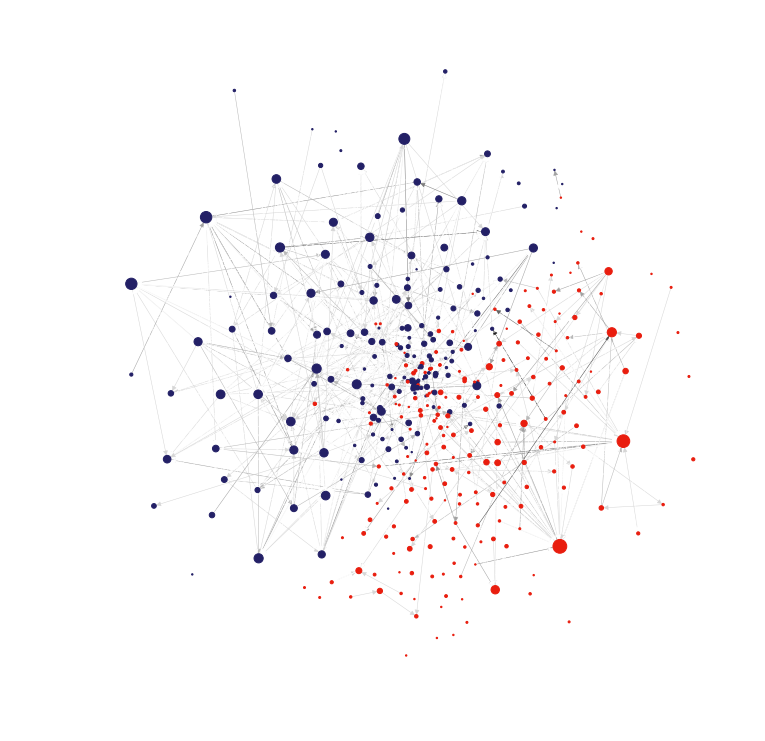

In [6]:
#-------
# DRAW
#-------

fig = plt.figure(figsize=(13, 13))
nx.draw_networkx(G, positions, 
                 node_size = sizes, node_color = colors, 
                 with_labels=False, edges_list = edges, 
                 edge_color = [math.log10((w+1.0)) for w in weights], 
                 width = 0.5, edge_cmap=plt.cm.gray_r, arrows = True)
plt.savefig('RT.png', bbox_inches='tight')
plt.axis('off')
plt.show()

>Compare the network of Retweets with the network of Wikipedia pages (Week 5, exercise 2). Do you observe any difference? How do you explain them?

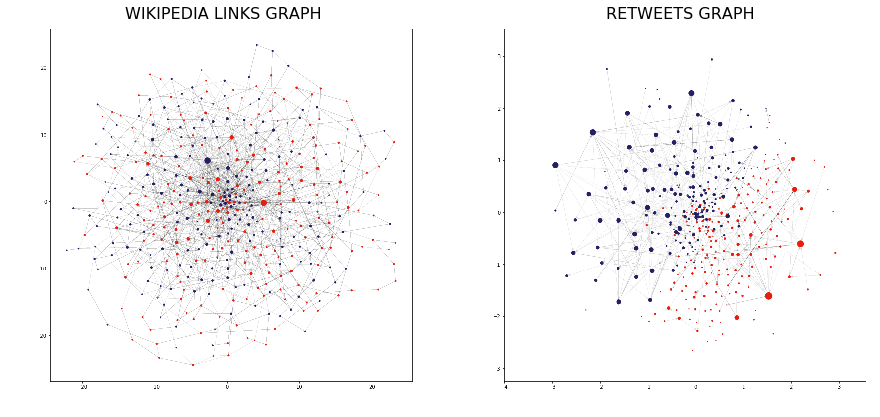

In [7]:
#-----------------------------------
# DISPLAY THE TWO DIFFERENT GRAPHS
#-----------------------------------
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15,7))

#WIKIPEDIA
ax = axs[0]
img=mpimg.imread('wikiNetwork.png')
imgplot = ax.imshow(img )
ax.axis('off')
ax.set_title("WIKIPEDIA LINKS GRAPH", fontdict=title_font)

#RETWEETS
ax = axs[1]
img=mpimg.imread('RT.png')
imgplot = ax.imshow(img )
ax.axis('off')
ax.set_title("RETWEETS GRAPH", fontdict=title_font)

plt.axis('off')
plt.show()

In the Wikipedia links graph, the democrats and republicans nodes are more mixed than in the retweets graph. Moreover, more links between Republicans and Democrats exist. <br>
This is due to the nature of the links. In the retweets network, the links correspond to retweets and congress members are keener on retweeting people from their own party to promote ideas they share, this results in a clearer division between republicans and democrats. In Wikipedia network, the links correspond to the presence of one politician in one other politician Wikipedia page. But those links can correspond to the fact that they come from the same state, that they participate in the same debate or commission in the Congress or from their role in the Congress. Then, it is more likely to have links between two members from different parties. <br>
In Wikipedia network, there are two major hubs which correspond to Congress member with important roles in the Congress. In the retweets network, there are no such major hubs. There are more nodes with. a bigger degree corresponding to politicians using twitter a lot but there is no major hub really dominating the network in term of degree.

#### Betweenness Centrality

> Now set the nodes' size proportional to their betweenness centrality. What do you observe?

In [8]:
#----------------------------
# GET BETWEENESS CENTRALITY
#----------------------------
betweenDict = nx.betweenness_centrality(G)
politicians = betweenDict.keys()
betweenessCentrality = [betweenDict[n] for n in politicians]

# Sort the congress members to highlight the congress members with the highest centrality
dBetween = {"Name" : politicians, "Betweeness Centrality" : betweenessCentrality}
dfBetween = (pd.DataFrame(dBetween)).sort_values("Betweeness Centrality", ascending = False)
print dfBetween.head(5)

# Build a label dictionnary with the name of the congress members to highlight
SortedNames = np.asarray(dfBetween["Name"])
SortedNames = SortedNames[:5]
labels = {}
for n in G.nodes():
    if n in SortedNames:
        labels[n]="\n\n\n\n"+n
    else:
        labels[n]=""

     Betweeness Centrality            Name
370               0.111113     SpeakerRyan
68                0.080558     NancyPelosi
162               0.077009  PatrickMcHenry
294               0.060828  RepDavidEPrice
69                0.055045    SteveScalise


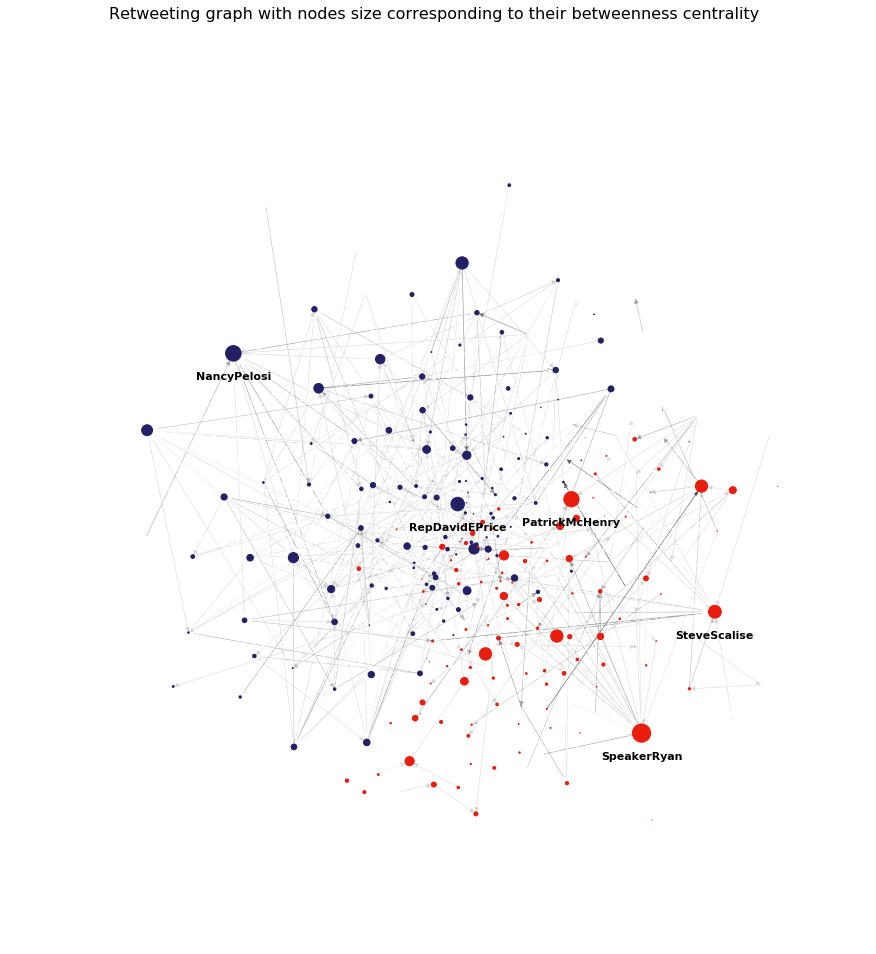

In [9]:
#-------
# DRAW
#-------

fig = plt.figure(figsize=(15, 15))
nx.draw_networkx(G, positions, node_size = [3000*betweenDict[member] for member in G.nodes()], 
                 node_color = colors, with_labels=True, edges_list = edges, 
                 edge_color = [math.log10((w+1.0)) for w in weights], width = 0.5, 
                 edge_cmap=plt.cm.gray_r, arrows = True, labels = labels, font_size = 11, font_weight= "bold")
plt.suptitle("Retweeting graph with nodes size corresponding to their betweenness centrality", fontsize = 16)
plt.axis('off')
plt.show()

The betweenness centrality quantifies the likeliness of a node to be in the shortest path of two other nodes. We see that hubs here appear. They correspond to Congress members who are retweeted many times and who retweets member from his/her own party but also from the opposite party, making links between members. It is then normal to see that the two members with the highest betweenness centrality have important positions inside the Congress:
* **Paul Ryan** (@SpeakerRyan): The speaker of the Congress 
* **Nancy Pelosi** (@NancyPelosi): The minority leader

#### Eigenvector Centrality

>Repeat the point above using eigenvector centrality instead. Is there any difference? Can you explain why?

In [10]:
#----------------------------
# GET EIGENVECTOR CENTRALITY
#----------------------------
eigenDict = nx.eigenvector_centrality(G)
politicians = eigenDict.keys()
eigenCentrality = [eigenDict[n] for n in politicians]

# Sort the congress members to highlight the congress members with the highest centrality
dEigen = {"Name" : politicians, "Eigenvector Centrality" : eigenCentrality}
dfEigen = (pd.DataFrame(dEigen)).sort_values("Eigenvector Centrality", ascending = False)
print dfEigen.head(5)

# Build a label dictionnary with the name of the congress members to highlight
SortedNames = np.asarray(dfEigen["Name"])
SortedNames = SortedNames[:5]
labels = {}
for n in G.nodes():
    if n in SortedNames:
        labels[n]="\n\n\n"+n
    else:
        labels[n]=""

     Eigenvector Centrality             Name
343                0.273884     repmarkpocan
153                0.243451  RepRaulGrijalva
107                0.233585      RepCummings
69                 0.227032      NancyPelosi
268                0.196892   RepTerriSewell


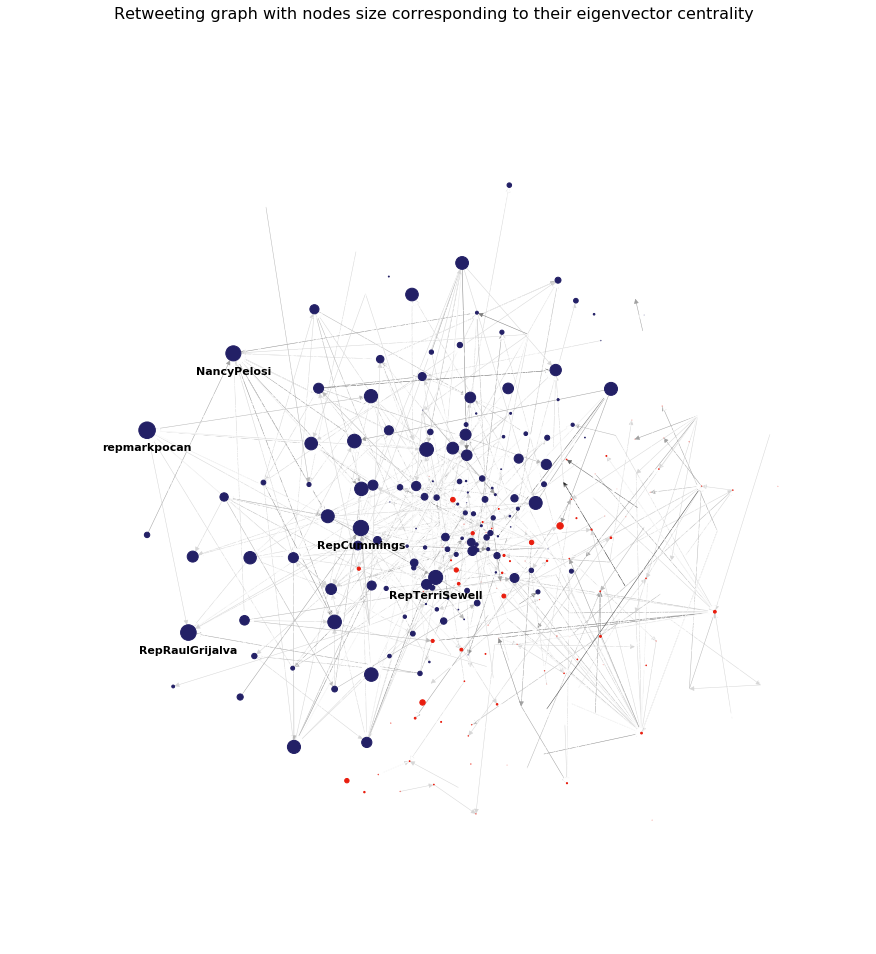

In [11]:
#-------
# DRAW
#-------

fig = plt.figure(figsize=(15, 15))
nx.draw_networkx(G, positions, node_size = [1000*eigenDict[member] for member in G.nodes()], 
                 node_color = colors, with_labels=True, edges_list = edges, 
                 edge_color = [math.log10((w+1.0)) for w in weights], width = 0.5, 
                 edge_cmap=plt.cm.gray_r, arrows = True, labels = labels,font_size = 11, font_weight= "bold")
plt.axis('off')
plt.suptitle("Retweeting graph with nodes size corresponding to their eigenvector centrality", fontsize = 16)
plt.show()

We observe a big difference between Democrats eigenvector centrality and Republicans ones. The eigenvector centrality measures the tendency of a node to be connected with high eigenvector centrality nodes. So this illustrates that Democrats are well connected between them giving high importance to everyone whereas republican tends to have big hubs everyone is retweeting. but then the retweeting members don't have high eigenvector centrality neither do their hubs.

> Who are the three nodes with highest degree within each party? And eigenvector centrality? And betweenness centrality?

In [12]:
#----------------------------------
# COMPILE ALL DATA IN A DATAFRAME
#----------------------------------

df["degree"] = pd.Series(np.zeros(len(names)))
df["betweenessCentrality"] = pd.Series(np.zeros(len(names)))
df["EigenvectorCentrality"] = pd.Series(np.zeros(len(names)))

for i in df.index:
    name =df.loc[i].at["tw_name"]
    df.loc[i, "degree"]= G.degree(name)
    df.loc[i, "betweenessCentrality"] = betweenDict[name]
    df.loc[i, "EigenvectorCentrality"] = eigenDict[name]

In [13]:
#---------------------------------------------------
# FIND THE THREE BEST MEMBERS BY CENTRALITY METHOD
#---------------------------------------------------

#DEGREE
df = df.sort_values("degree", ascending=False).reset_index(drop=True)
print "The three Congress members with the highest Degree are:"
for i in range(3):
    print( "- "+str(df.loc[i].at["degree"])+"   "+df.loc[i].at["tw_name"] +"   ("+df.loc[i].at["Party"]+")")
    
print 

#BETWEENNESS CENTRALITY
df = df.sort_values("betweenessCentrality", ascending=False).reset_index(drop=True)
print "The three Congress members with the highest Betweenness Centrality are:"
for i in range(3):
    print( "- "+str(round(df.loc[i].at["betweenessCentrality"],3))+"   "+df.loc[i].at["tw_name"] +"   ("+df.loc[i].at["Party"]+")")

print 

#EIGENVECTOR CENTRALITY
df = df.sort_values("EigenvectorCentrality", ascending=False).reset_index(drop=True)
print "The three Congress members with the highest Eigenvector Centrality are:"
for i in range(3):
    print( "- "+str(round(df.loc[i].at["EigenvectorCentrality"],3))+"   "+df.loc[i].at["tw_name"] +"   ("+df.loc[i].at["Party"]+")")

The three Congress members with the highest Degree are:
- 95.0   SpeakerRyan   (Republican)
- 80.0   SteveScalise   (Republican)
- 65.0   NancyPelosi   (Democratic)

The three Congress members with the highest Betweenness Centrality are:
- 0.111   SpeakerRyan   (Republican)
- 0.081   NancyPelosi   (Democratic)
- 0.077   PatrickMcHenry   (Republican)

The three Congress members with the highest Eigenvector Centrality are:
- 0.274   repmarkpocan   (Democratic)
- 0.243   RepRaulGrijalva   (Democratic)
- 0.234   RepCummings   (Democratic)


* **Paul Ryan** (@SpeakerRyan) is the speaker of the Congress
* **Steve Scalise** (@SteveScalise) is the majority whip
* **Nancy Pelosi** (@NancyPelosi) is the minority leader
* **Patrick McHenry** (@PatrickMcHenry) is the chief deputy whip
* **Mark Pocan** (@MarkPocan) is Co-Chair of both the Congressional Progressive Caucus, as well as the Congressional LGBT Equality Caucus.
* **Raul Grijalva** (@RepRaulGrijalva) is a Democrat congress member from Arizona
* **Elijah Cummings** (@RepCummings) is a Democrat congress member from Maryland

Degree ans Betweeness centrality tends to highlight congress member with importance inside the congress whereas the Eigenvector centrality highlights other members

#### Outgoing Strength

>Plot on the same figure the distribution of outgoing strength for the republican and democratic nodes (e.g. the sum of the weight on outgoing links). Which party is more active in retweeting other members of the house?

In [14]:
#----------------------------
# COMPUTE OUTGOING STRENGTH
#----------------------------

# Store them in a list
DemocratsOutGoingStrength = []
RepublicanOutGoingStrength = []

for n in G.nodes():                                           # Go through all nodes
    ogStrength = 0
    edges = list(G.out_edges(n))
    for e in edges:
        ogStrength += G.get_edge_data(*e).values()[0]         # Compute the outgoing strenght
    if G.nodes[n]["party"] == "Republican":                   # Store it in the correponding list
        RepublicanOutGoingStrength.append(ogStrength)
    else:
        DemocratsOutGoingStrength.append(ogStrength)

In [15]:
#---------------------
# HISTOGRAM FUNCTION
#---------------------

def histogram(degrees):
    # Computing Bins
    min_bin = np.amin(degrees)
    max_bin = np.amax(degrees)
    nb_bins = int(max_bin)-int(min_bin)
    v = np.empty(nb_bins+1)
    v[nb_bins] = int(max_bin)
    bins = np.empty(nb_bins)
    for i in range(nb_bins):
        v[i] = int(min_bin + i)
        bins[i] = int(min_bin + i)

    #Hist
    hist, bin_edges = np.histogram(degrees,bins = v)
    return hist, bin_edges

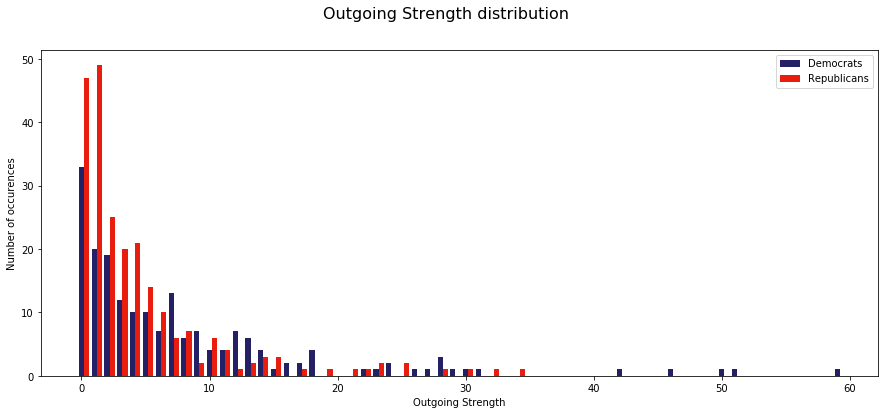

In [16]:
#------------------------
# DISPLAY THE HISTOGRAM 
#------------------------

# Get the histograms
histD, binsD = histogram(DemocratsOutGoingStrength)
histR, binsR = histogram(RepublicanOutGoingStrength)
binsR = [v+0.4 for v in binsR] # offset to separate the bins

# Plot
plt.figure(figsize = (15,6))
plt.bar(binsD[:-1], histD, 0.4, color=democraticBlue, label = "Democrats")
plt.bar(binsR[:-1], histR, 0.4, color=republicanRed, label = "Republicans")
plt.xlabel('Outgoing Strength')
plt.ylabel('Number of occurences')
plt.suptitle('Outgoing Strength distribution', fontsize=16)
plt.legend()
plt.show()

Democrates are more active retweeting the other member of the congress

#### Cross Party Retweets

>Find the 3 members of the republican party that have retweet more often tweets from democratic members. Repeat the measure for the democratic members. Can you explain your results by looking at the Wikipedia pages of these members of the house?

In [17]:
#-------------------------
# COMPUTE CROSS RETWEETS
#-------------------------

df["CrossRetweets"] = pd.Series(np.zeros(len(names)))

for i in df.index:                                           # Go through all congress members
    name = df.loc[i].at["tw_name"]                                
    edges = list(G.out_edges(name))                          # Retrieve the edges corresponding to the politician
    cross = 0
    for (u,v) in edges:                                      # Go through the edges
        if G.nodes[v]["party"] != G.nodes[u]["party"]:
            cross += G.get_edge_data(u,v).values()[0]        # Add it if it is a cross party RT
    df.loc[i, "CrossRetweets"] = cross

            
# Separate Republicans and Democrats and sort them
df_rep = (df[df['Party'] == "Republican"]).sort_values("CrossRetweets", ascending=False).reset_index(drop=True)
df_dem = (df[df['Party'] != "Republican"]).sort_values("CrossRetweets", ascending=False).reset_index(drop=True)

# Display
print "The three Democrats Congress Members retweeting Republicans the most often are:"
for i in range(3):
    print "- "+df_dem.loc[i].at["tw_name"]+" -> "+str(df_dem.loc[i].at["CrossRetweets"])+" times"
print
print "The three Republicans Congress Members retweeting Democrats the most often are:"
for i in range(3):
    print "- "+df_rep.loc[i].at["tw_name"]+" -> "+str(df_rep.loc[i].at["CrossRetweets"])+" times"

The three Democrats Congress Members retweeting Republicans the most often are:
- RepAnnaEshoo -> 3.0 times
- RepDebDingell -> 3.0 times
- RepLoisFrankel -> 2.0 times

The three Republicans Congress Members retweeting Democrats the most often are:
- CongressmanGT -> 5.0 times
- RepMikeTurner -> 5.0 times
- RepRyanCostello -> 5.0 times


**DEMOCRATS**
* **Anna Eshoo** (@RepAnnaEshoo) is a Democrat member of the Committee on Energy and Commerce
* **Debbie Dingell** (@RepDebDingell) is a Democrat member of the Committee on Energy and Commerce, she was a Republican before 1981
* **Lois Frankel** (@RepLoisFrankel) is a Democrat member of Committee on Foreign Affairs and of theCommittee on Transportation and Infrastructure

**REPUBLICANS**
* **Glenn Thompson** (@CongressmanGT) is a Republican Congress Member, but his position on gun legislation and some other areas are closer to Democrats positions
* **Mike Turner** (@RepMikeTurner) is a Republican member of the Committee on Armed Services and the Committee on Oversight and Government Reform
* **Ryan Costello** (@RepRyanCostello) is a Republican Congress member. He is known to be one of the most bipartisan congress members.

We cannot say much about the Democrats in this case but the Republicans who retweet the most Democrats tends to be more moderate and bipartisan according to their Wikipedia page.

### Exercise 3: Community detection.

>Use your favorite method of community detection to find communities in the full house of representatives network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found for the Wikipedia network? Comment on your result.

In [18]:
#------------------------------
# COMPUTE COMMUNITY DETECTION
#------------------------------

# We used the Louvain algorithm
partition = community.best_partition(G.to_undirected())

# Compute the modularity
modularity = community.modularity(partition,G.to_undirected())

wikiModularity = 0.4741050177755293  # modularity of the wikipedia graph

print "The partition made of the retweet graph has a modularity of +"+str(round(modularity*100,3))+"%"
print "The partition made of the wikipedia graph has a modularity of +"+str(round(wikiModularity*100,3))+"%"


The partition made of the retweet graph has a modularity of +47.502%
The partition made of the wikipedia graph has a modularity of +47.411%


The modularities obtained are really similar.They are positive, meaning that the nodes of each communities are more connected than expected.

#### Plotting

> Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2). This time assign each node a different color based on their community. Describe the structure you observe.

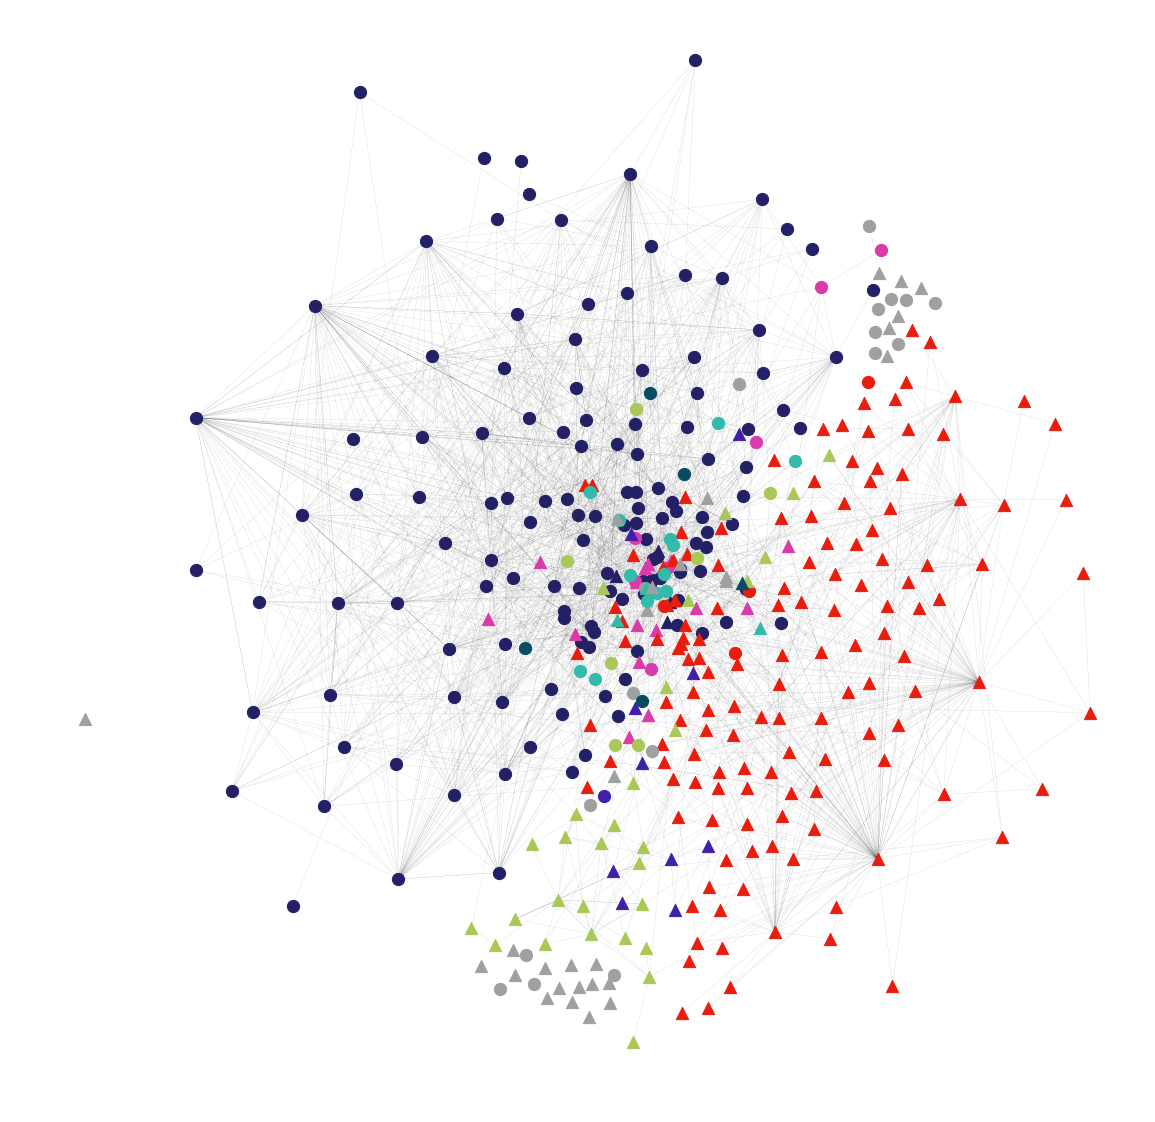

In [19]:
#-----------------------
# PLOT THE COMMUNITIES
#-----------------------

# Define a color range to differentiate the communities
colorRange = np.asarray([democraticBlue,'#db3aAA',republicanRed,'#aac857','#32BBAA','#4020AA','#084c61','#407058','#177e89','#bbcdcd'])

# Drawing
fig = plt.figure(figsize=(20, 20))
nextColor =0            # Color count to go through the color range
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()            # Go throught the communities built
                                if partition[nodes] == com]
    if len(list_nodes)>4:                                        # Pick a color for the big communities 
        color = colorRange[nextColor]
        nextColor +=1
    else: # As there are a lot of 1 to 4 nodes communities we display them in grey for readability reasons
        color = "#A0A0A0"
        
    #Separate Republicans and Democrats
    list_nodes_rep = [nodes for nodes in list_nodes if G.nodes[nodes]["party"]=="Republican"]
    list_nodes_dep = [nodes for nodes in list_nodes if G.nodes[nodes]["party"]!="Republican"]
    
    nx.draw_networkx_nodes(G, positions, list_nodes_rep, node_size = 150,
                                node_color = color, node_shape="^")  # Plot Republicans as triangles
    nx.draw_networkx_nodes(G, positions, list_nodes_dep, node_size = 150,
                                node_color = color, node_shape="o")  # Plot Democrates as circles


nx.draw_networkx_edges(G,positions,  width = 0.1, arrows=False, alpha=0.5) # Draw the edges
plt.axis('off')
plt.show()

We observe two distinct large communities correponding roughly to Republicans and Democrats. Some smaller, more shared communities in between and a bunch of nodes belonging to really small communities mostly on the outside of the representation with few links

#### Confusion Matrix

>Compare the communities found by your algorithm with the parties by creating a matrix $\mathbf{D}$ with dimension $(B \times C$, where $B$ is the number of parties and $C$ is the number of communities. We set entry $D(i,j)$ to be the number of nodes that party $i$ has in common with community $j$. The matrix $\mathbf{D}$ is what we call a confusion matrix.

In [20]:
#--------------------------
# COMMUNITY SIZE FUNCTION
#--------------------------

#  Define a community size function to sort the community by size computing the confusion matrix.
def community_Size(com):
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    return len(list_nodes)

In [21]:
#-------------------------------
# COMPUTE THE CONFUSION MATRIX
#-------------------------------

D = np.zeros((2, len(set(partition.values()))),dtype = int) # Define the matrix

i=0 # Set a count
for com in sorted(set(partition.values()),key = community_Size, reverse =True) :  # Go through the partition
    rep = [nodes for nodes in partition.keys() 
           if partition[nodes] == com and G.nodes[nodes]["party"]=="Republican"]
    dem = [nodes for nodes  
           in partition.keys() if partition[nodes] == com and G.nodes[nodes]["party"]!="Republican"]
    D[0,i]=len(rep) # line 0 corresponds to the republicans
    D[1,i]=len(dem) # line 1 corresponds to the democrats
    i+=1

>Plot the confusion matrix and explain how well the communities you've detected correspond to the parties. Consider the following questions: <br>
* Are there any republicans grouped with democrats (and vice versa)?<br>
* Does the community detection algorithm sub-divide the parties? Do you know anything about American politics that could explain such sub-divisions? Answer in your own words.

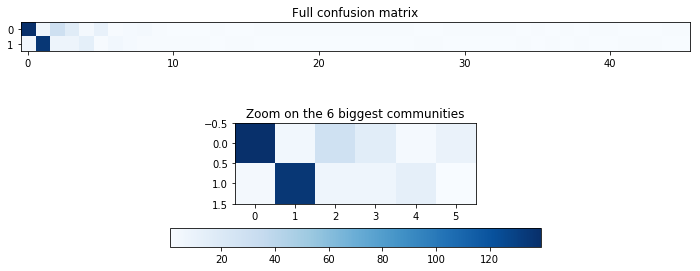

In [22]:
#----------------------------
# PLOT THE CONFUSION MATRIX
#----------------------------
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(211)
ax1.imshow(D, cmap=cm.Blues)
ax1.set_title("Full confusion matrix")

ax2 = fig.add_subplot(212)
# 'nearest' interpolation - faithful but blocky
im = ax2.imshow(D[:,:6], cmap=cm.Blues)
ax2.set_title("Zoom on the 6 biggest communities")
fig.colorbar(im, orientation = "horizontal", pad=0.2)
plt.show()

To make it clearer, let's compute the confusion matrix in percentage: $D(i,j)$ being the pencentage of community $j$ nodes that are $i$ (NB: $i$ is Republican or Democrat)

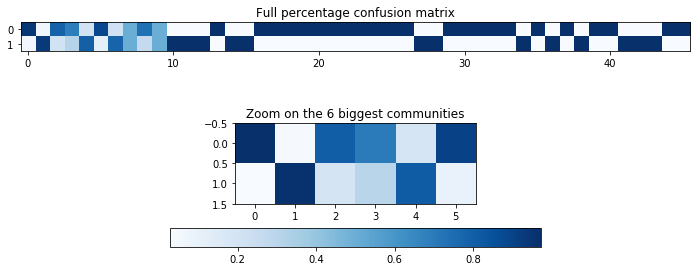

In [23]:
#------------------------------------------
# COMPUTE THE PERCENTAGE CONFUSION MATRIX
#------------------------------------------

D_percentage = np.zeros((2, len(set(partition.values()))),dtype = float)   # Define the matrix
for i in range(len(set(partition.values()))):
    for j in range(2):
        D_percentage[j,i]= D[j,i]/(D[0,i]+D[1,i])                          # Compute it
        
#PLOT
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(211)
ax1.imshow(D_percentage, cmap=cm.Blues)
ax1.set_title("Full percentage confusion matrix")

ax2 = fig.add_subplot(212)
im=ax2.imshow(D_percentage[:,:6], cmap=cm.Blues)
ax2.set_title("Zoom on the 6 biggest communities")

fig.colorbar(im, orientation = "horizontal", pad=0.2)
plt.show()

Doing this, we see that communities 0, 1 and 5 are really separated while communities 2, 3 and 4 are more mixed.
To see to what extend this separate correctly republicans and democrate let's compute the error rate of this classification.

In [24]:
#-------------------------
# COMPUTE THE ERROR RATE
#-------------------------

#FOR EACH COMMUNITY
ErrorRate = np.zeros((len(set(partition.values()))),dtype = float)
for i in range(len(set(partition.values()))):
    if D[0,i]>D[1,i]:                                 # The error rate is the proportion of member of the less 
        ErrorRate[i]= D[1,i]/(D[0,i]+D[1,i])*100      # represented party of the considered community
    else:
        ErrorRate[i]= D[0,i]/(D[0,i]+D[1,i])*100
        
#TOTAL ERROR RATE   
TotalErrorRate = 0
for i in range(len(set(partition.values()))):
    if D[0,i]>D[1,i]:
        TotalErrorRate += D[1,i]
    else:
        TotalErrorRate += D[0,i]
TotalErrorRate = TotalErrorRate/ G.number_of_nodes()

print "The total error rate is "+str(round(TotalErrorRate*100,2))+"%"

The total error rate is 7.62%


To conclude those communities respect pretty much to the parties of the members.

Let's plot the histogram of the proportion of members in each community regarding their party

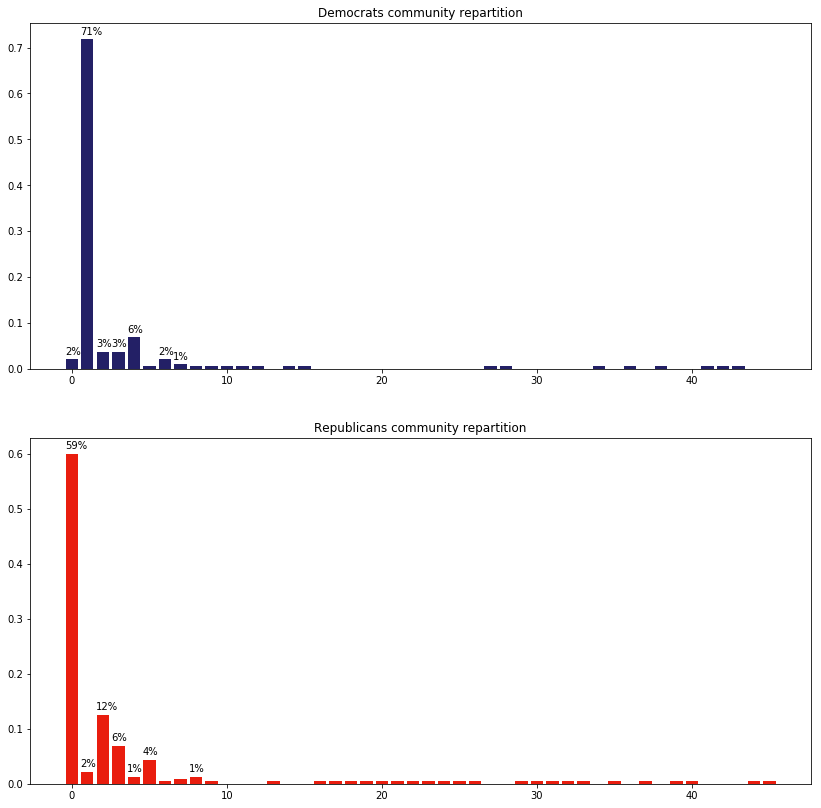

In [25]:
#--------------------------------------
# COMPUTE THE PARTY PERCENTAGE MATRIX
#--------------------------------------

P_percentage = np.zeros((2, len(set(partition.values()))),dtype = float)   # Define the matrix

#Compute the number of member by parties
n_rep = 0
n_dem = 0
for i in range(len(set(partition.values()))):
    n_rep += D[0,i]
    n_dem += D[1,i]
#Compute P_percentage
for i in range(len(set(partition.values()))):
    P_percentage[0,i]= D[0,i]/ n_rep                     # Compute it
    P_percentage[1,i]= D[1,i]/ n_dem
    
#PLOT
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(211)
ax1.bar([i for i in range(len(set(partition.values())))], P_percentage[1,:], 0.8, color=democraticBlue, label = "Democrats")
ax1.set_title("Democrats community repartition")
for p in ax1.patches:
    if int(p.get_height()*100) != 0:
        ax1.annotate(str(int(p.get_height()*100))+"%", (p.get_x()-0.05, p.get_height()+0.01))
    
ax2 = fig.add_subplot(212)
ax2.bar([i for i in range(len(set(partition.values())))], P_percentage[0,:], 0.8, color=republicanRed, label = "Republicans")
ax2.set_title("Republicans community repartition")
for p in ax2.patches:
    if int(p.get_height()*100) != 0:
        ax2.annotate(str(int(p.get_height()*100))+"%", (p.get_x()-0.05, p.get_height()+0.01))

plt.show()

Democrats are roughly in the same community (71%) and the rest is spread amongst the other communities without big batches.
For the Republicans the majority is in the same community (59%) but there are also other communities with consequent amount of Republicans. That might be explain be the fact that there are different lines within the republican party: from Tea party and very conservative ones to more moderate ones